## Conociendo el entorno

Para conocer la información de Hardware de la máquina en que se corre en cuestión.

In [ ]:
! lscpu

## Instalando dependencias necesarias

In [ ]:
! pip install matplotlib
! pip install ipyparallel

## Código del juego de la vida de Conway

### Versión secuencial

In [ ]:
# Version SECUENCIAL del juego de la vida de Conway
#
# Autor: John Sanabria - john.sanabria@correounivalle.edu.co
# Fecha: 2023-02-22

import numpy as np
from time import time

import matplotlib.pyplot as plt 

MAX_X = 512
MAX_Y = 512

#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#
def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y) 

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#                 |                |

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]
#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas 
# vivirán y cuales no 
#
def conway(vector_out, vector_in, low_limit = 0, high_limit = MAX_X):
  for i in range(low_limit,high_limit):
    for j in range(0,MAX_Y):
      n = vecinos(i,j, vector_in)
      valor = 0
      if vector_in[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector_in[ indice(i,j) ] == 0 and n == 3:
        valor = 1
      vector_out[ indice(i,j) ] = valor

#
# Función principal
#
if __name__ == '__main__':
  vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
  vector_out = np.empty(MAX_X * MAX_Y, dtype = np.int32)
  print(vector)
  t1 = time()
  conway(vector_out, vector)
  t2 = time()
  print(vector_out)
  print(f"El tiempo que tomó calcular {t2 - t1}")
  fig = plt.figure()
  plt.imshow(vector_out.reshape(MAX_X,MAX_Y))
  plt.show()  

### Versión paralelizada (ipyparallel)

Se realizan las respectivas importaciones

In [5]:
#Esto es para visualizar la imágen
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import ipyparallel as parallel
import time

Definimos algunas variables globales para el código del juego de la vida de Conway y también del código encargado de la paralelización

In [12]:
MAX_UNITS = 4 #Numero de unidades (Divisiones de la malla)

def calcular_constante(n, constante = 1):
  if (n==4):
    return int(constante * 2)
  else:
    return calcular_constante(n/4, constante*2)

MAX_UNITS_POR_FILA = int(MAX_UNITS/calcular_constante(MAX_UNITS))
MAX_X = 16 #Dimensión en X de la grilla
MAX_Y = 16 #Dimensión en Y de la grilla total
SUBMAX_X = int(MAX_X/MAX_UNITS_POR_FILA) #Dimensión en X de la subgrilla
SUBMAX_Y = int(MAX_Y/MAX_UNITS_POR_FILA) #Dimensión en Y de la subgrilla

Se definen las respectivas funciones que se encargan de calcular el juego de la vida de Conway

In [13]:
#
# Funciones auxiliares usadas para estimar los vecinos de una celda y
# garantizar que los valores del borde no se vayan a sobrepasar
#

def posx(x, max_x = MAX_X):
  return (x + max_x) % max_x #2

def posy(y, max_y = MAX_Y):
  return (y + max_y) % max_y #1

def indice(x,y, max_y = MAX_Y):
  return posx(x) * max_y + posy(y) # 16

def subposx(x, max_x = SUBMAX_X):
  return (x + max_x) % max_x

def subposy(y, max_y = SUBMAX_Y):
  return (y + max_y) % max_y

def subindice(x,y, max_y = SUBMAX_Y):
  return posx(x) * max_y + posy(y)

#
# Esta funcion se encarga de contar los 8 vecinos de una celda cuales están
# vivos (valor a '1') o cuantos están muertos (valor a '0')
#
#                 |                |
#  (X - 1, Y - 1) | (  X  , Y - 1) | (X + 1, Y - 1)
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1,   Y  ) | (  X  ,   Y  ) | (X + 1,   Y  )
#                 |                |
# --------------------------------------------------
#                 |                |
#  (X - 1, Y + 1) | (  X  , Y + 1) | (X + 1, Y + 1)
#

def vecinos(x,y,vector):
  return vector[ indice(x - 1, y - 1) ] + vector[ indice(x - 1, y) ] + vector[ indice(x - 1, y + 1) ] \
  + vector[ indice(x, y - 1) ] + vector[ indice(x, y + 1) ] \
  + vector[ indice(x + 1, y - 1) ] + vector[ indice(x + 1, y) ] + vector[ indice(x + 1, y + 1) ]

def imprimir_vecinos(x,y):
    print(f"La posicion ({x},{y}) paso de {vector[indice(x,y)]} a {vector_out[indice(x,y)]}")
    print("Sus vecinos eran")
    print(f"{vector[ indice(x - 1, y - 1) ]}, {vector[ indice(x - 1, y) ]}, {vector[ indice(x - 1, y + 1)]}")
    print(f"{vector[ indice(x, y - 1) ]}, X, {vector[ indice(x, y + 1) ]}")
    print(f"{vector[ indice(x + 1, y - 1) ]}, {vector[ indice(x + 1, y) ]}, {vector[ indice(x + 1, y + 1) ]}")
    
#
# Esta función se encarga de recorrer toda las celdas y estimar cuales de ellas 
# vivirán y cuales no 
#
def conway(vector_out, vector_in, stride_x, stride_y):
  for i in range(stride_x,SUBMAX_X+stride_x):
    for j in range(stride_y,SUBMAX_Y+stride_y):
      n = vecinos(i,j, vector_in)
      valor = 0
      if vector_in[ indice(i,j) ] == 1 and (n == 2 or n == 3):
        valor = 1
      elif vector_in[ indice(i,j) ] == 0 and n == 3:
        valor = 1
        
      if (i >= SUBMAX_X):
        i1 = i-stride_x
      else:
        i1 = i

      if (j >= SUBMAX_Y):
        j1 = j-stride_y
      else:
        j1 = j
          
      vector_out[ subindice(i1,j1) ] = valor
  return vector_out

# Wrapper utilizado para la paralelización
def conway_wrapper(args):
    vector_out, vector_in, x, y = args
    return conway(vector_out, vector_in, x, y)

## Hora de paralelizar

Se conecta con el respectivo *Client* paralelo

In [14]:
rc = parallel.Client()
all_engines = rc[:]
view = rc.load_balanced_view()

Se proceden a definir los respectivos *namespaces* en cada uno de los *engines* con imports

In [15]:
%%px
import time
import numpy as np

Procedemos a inicializar cada una de las funciones declaradas anteriormente en cada uno de los *engines*

In [17]:
all_engines.push(dict(
    posx=posx,
    posy=posy,
    indice=indice,
    subposx=subposx,
    subposy=subposy,
    subindice=subindice,
    vecinos=vecinos,
    imprimir_vecinos=imprimir_vecinos, #Creo que no es necesario
    conway=conway,
    SUBMAX_X=SUBMAX_X,
    SUBMAX_Y=SUBMAX_Y,
))

<AsyncResult(_push): pending>

Ahora es posible iterar sobre cada uno de los sub-espacios disponibles para calcular el juego de la vida de Conway

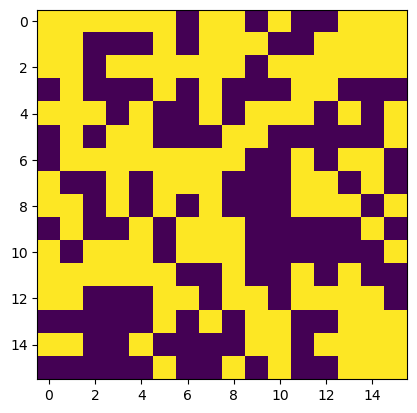

In [18]:
vector = np.int32( np.random.choice([1,0], MAX_X * MAX_Y, p = [0.50, 0.50]) )
fig = plt.figure()
plt.imshow(vector.reshape(MAX_X,MAX_Y))
plt.show()

In [ ]:
stride = SUBMAX_X
count = 0

vector_out = np.empty(stride * stride, dtype = np.int32)

# Creación de una lista de listas para los argumentos
arguments_list = []
for x in range(0, MAX_X, SUBMAX_X):
  for y in range(0, MAX_Y, SUBMAX_Y):
    arguments_list.append((vector_out, vector, x, y))


# Medir tiempo de inicio
t1 = time.time()

# Usando el load_balanced_view para distribuir el trabajo
amr = view.map_async(conway_wrapper, arguments_list, ordered=True)

# Esperar por los resultados
results = amr.get()

# Medir tiempo final
t2 = time.time()

# Tiempo de ejecución
print(f"El tiempo que tomó calcular: {t2 - t1}")

# Transformar a submatrices
for i in range(0, MAX_UNITS):
  results[i] = results[i].reshape(SUBMAX_X,SUBMAX_Y)
    
# Inicializar finalResult
finalResult = []

def concatenarFilas(array, row):
  final = []
  section = int(row // SUBMAX_X)
  row = int(row % SUBMAX_X)
  for i in range(section*MAX_UNITS_POR_FILA,section*MAX_UNITS_POR_FILA+MAX_UNITS_POR_FILA):
    subArray = array[i].tolist()
    final += subArray[row]

  return final

for row in range(0, MAX_X):
  finalResult.append(concatenarFilas(results, row))

finalResult = np.array(finalResult)

fig = plt.figure()
plt.imshow(finalResult.reshape(MAX_X,MAX_Y))
plt.show()